## Functional programming

### Functional Programming


Understanding to think in a *functional programming* style is almost as
important as object orientation for building DRY, clear scientific software,
and is just as conceptually difficult.

Programs are composed of functions: they take data in (which we call
*parameters* or *arguments*) and send data out (through `return` statements.)

A conceptual trick which is often used by computer scientists to teach the core
idea of functional programming is this: to write a program,
in theory, you only ever need functions with **one** argument, even when you think you need two or more. Why?

Let's define a program to add two numbers:




In [1]:
def add(a,b):
    return a+b

add(5,6)

11



How could we do this, in a fictional version of Python which only defined functions of one argument?
In order to understand this, we'll have to understand several of the concepts
of functional programming. Let's start with a program which just adds five to
something:




In [2]:
def add_five(a):
    return a+5

add_five(6)

11



OK, we could define lots of these, one for each number we want to add. But that
would be infinitely repetitive. So, let's try to metaprogram that: we want a
function which returns these add_N() functions.

Let's start with the easy case: a function which returns a function which adds 5 to something:




In [3]:

def generate_five_adder():
    def _add_five(a):
        return a+5
    return _add_five

coolfunction = generate_five_adder()
coolfunction(7)


12



OK, so what happened there? Well, we defined a function **inside** the other function. We can always do that:




In [4]:
def thirty_function():
    def times_three(a):
        return a*3
    def add_seven(a):
        return a+7
    return times_three(add_seven(3))

thirty_function()

30



When we do this, the functions enclosed inside the outer function are **local** functions, and can't be seen outside:




In [5]:
add_seven

NameError: name 'add_seven' is not defined



There's not really much of a difference between functions and other variables
in python. A function is just a variable which can have () put after it to call
the code!




In [9]:
print thirty_function

<function thirty_function at 0x1116781b8>


In [10]:
x=[thirty_function, add_five, add]

In [11]:
for fun in x:
    print fun

<function thirty_function at 0x1116781b8>
<function add_five at 0x111678230>
<function add at 0x111678140>




And we know that one of the things we can do with a variable is `return` it. So we can return a function, and then call it outside:




In [12]:
def deferred_greeting():
    def greet():
        print "Hello"
    return greet

friendlyfunction=deferred_greeting()

In [14]:
# Do something else
print "Just passing the time..."

Just passing the time...


In [15]:
# OK, Go!
friendlyfunction()

Hello





So now, to finish this, we just need to return a function to add an arbitrary amount:




In [16]:
def define_adder(increment):
    def adder(a):
        return a + increment
    return adder

add_3=define_adder(3)

In [17]:
add_3(9)

12



We can make this even prettier: let's make another variable pointing to our define_adder() function:




In [18]:
add = define_adder



And now we can do the real magic:




In [19]:
add(8)(5)

13

### Closures

You may have noticed something a bit weird:

In the definition of `define_adder`, `increment` is a local variable. It should have gone out of scope and died at the end of the definition. How can the amount the returned adder function is adding still be kept?

This is called a **closure**. In Python, whenever a function definition references a variable in the surrounding scope, it is preserved within the function definition.

You can close over global module variables as well:




In [20]:
name = "James"

def greet():
    print "Hello, ", name

greet()

Hello,  James




And note that the closure stores a reference to the variable in the surrounding scope: ("Late Binding")




In [21]:
name="Matt"

greet()

Hello,  Matt


### Map and Reduce

We often want to apply a function to each variable in an array, to return a new array. We can do this with a list comprehension:




In [22]:
numbers=range(10)

[add_five(i) for i in numbers]

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14]



But this is sufficiently common that there's a quick built-in:




In [23]:
map(add_five, numbers)

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14]



This **map** operation is really important conceptually when understanding
efficient parallel programming: different computers can apply the *mapped*
function to their input at the same time. We call this Single Program, Multiple
Data. (SPMD) **map** is half of the **map-reduce** functional programming
paradigm which is key to the efficient operation of much of today's "data
science" explosion. 

Let's continue our functional programming mind-stretch by looking at **reduce** operations.

We very often want to loop with some kind of accumulator, such as when finding a mean, or finding a maximum:




In [25]:
def summer(data):
    sum = 0.0
    
    for x in data:
        sum+=x
        
    return sum

In [26]:
summer(range(10))

45.0

In [28]:
import sys

def my_max(data):
    # Start with the smallest possible number
    highest = sys.float_info.min
    
    for x in data:
        if x>highest:
            highest=x
            
    return highest

In [29]:
my_max([2,5,10,-11,-5])

10

These operations, where we have some variable which is building up a result,
and the result is updated with some operation, can be gathered together as a
functional program, taking in the operation to be used to combine results as an
argument:

In [31]:
def accumulate(initial, operation, data):
    accumulator=initial
    for x in data:
        accumulator=operation(accumulator, x)
    return accumulator

def my_sum(data):
    def _add(a,b):
        return a+b
    return accumulate(0, _add, data)

In [32]:
my_sum(range(5))

10

In [33]:
def bigger(a,b):
    if b>a:
        return b
    return a

def my_max(data):
    return accumulate(sys.float_info.min, bigger, data)

my_max([2,5,10,-11,-5])

10



Now, because these operations, _bigger, and _add, are such that e.g. (a+b)+c = a+(b+c) , i.e. they are **associative**, we could apply our accumulation
to the left half and the right half of the array, each on a different computer, and then combine the two halves:

1+2+3+4=(1+2)+(3+4)

Indeed, with a bigger array, we can divide-and-conquer more times:

1+2+3+4+5+6+7+8=((1+2)+(3+4))+((5+6)+(7+8))

So with enough parallel computers, we could do this operation on eight numbers
in three steps: first, we use four computers to do one  each of the pairwise
adds.

Then, we use two computers to add the four totals.

Then, we use one of the computers to do the final add of the two last numbers.

You might be able to do the maths to see that with an N element list, the
number of such steps is proportional to the logarithm of N.

We say that with enough computers, reduction operations are O(ln N)

This course isn't an introduction to algorithms, but we'll talk more about this
O() notation when we think about programming for performance.

Anyway, this accumulate-under-an-operation process, is so fundamental to
computing that it's usually in standard libraries for languages which allow
functional programming:




In [34]:
from functools import reduce

def my_max(data):
    return reduce(bigger, data, sys.float_info.min)

my_max([2,5,10,-11,-5])

10

### Lambda Functions



When doing functional programming, we often want to be able to define a function on the fly:




In [35]:
def most_Cs_in_any_sequence(sequences):
    
    def count_Cs(sequence):
        return sequence.count('C')
    
    counts=map(count_Cs, sequences)
    return max(counts)

def most_Gs_in_any_sequence(sequences):
    return max(map(lambda sequence: sequence.count('G'),sequences))

data=[
    "CGTA",
    "CGGGTAAACG",
    "GATTACA"
]

most_Gs_in_any_sequence(data)

4



The syntax here is that these two definitions are identical:




In [36]:
func_name=lambda a,b,c : a+b+c

def func_name(a,b,c):
    return a+b+c




lambda defines an "anonymous" function.




In [37]:
def most_of_given_base_in_any_sequence(sequences, base):
    return max(map(lambda sequence: sequence.count(base), sequences))

most_of_given_base_in_any_sequence(data,'A')

3



The above fragment defined a lambda function as a **closure** over `base`. If you understood that, you've got it! 




In [38]:
def my_max(data): return reduce(lambda a,b: a if a>b else b, data,
        sys.float_info.min)

my_max([2,5,10,-11,-5])

10

### Using functional programming for numerical methods


Probably the most common use in research computing for functional programming
is the application of a numerical method to a function. For example:


In [39]:
% matplotlib inline

1.0 -3.44190514264e-21


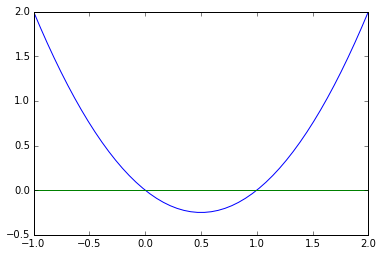

In [40]:
from scipy.optimize import newton
from numpy import linspace, zeros
from matplotlib import pyplot as plt

solve_me=lambda x: x**2-x

print newton(solve_me, 2), newton(solve_me,0.2)

xs=linspace(-1,2,50)
solved=[xs,map(solve_me,xs),xs,zeros(50)]
plt.plot(*solved)




Sometimes such tools return another function:




In [41]:
def derivative(func, eps):
    
    def _func_derived(x):
        return (func(x+eps)-func(x))/eps
    
    return _func_derived

straight = derivative(solve_me, 0.01)

In [42]:
straight(3)

5.00999999999987

0.495


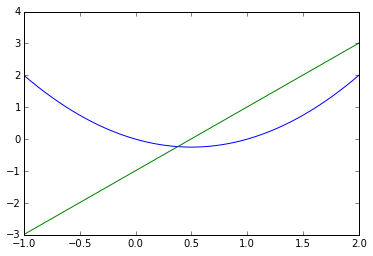

In [43]:
derived=(xs,map(solve_me,xs),xs,map(derivative(solve_me,0.01),xs))
plt.plot(*derived)
print newton(derivative(solve_me,0.01),0)

Of course, coding your own numerical methods is bad:

In [44]:
import scipy.misc

def derivative(func):
    def _func_derived(x):
        return scipy.misc.derivative(solve_me,x)
    return _func_derived

newton(derivative(solve_me),0)

0.5



If you've done a moderate amount of calculus, then you'll find similarities
between functional programming in computer science and Functionals in the
calculus of variations.

